In [1]:
import sympl 
from sympl import (
    DataArray, PlotFunctionMonitor,
    AdamsBashforth
)
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

from climt import (
    EmanuelConvection, RRTMGShortwave, RRTMGLongwave, SlabSurface,
    DryConvectiveAdjustment, SimplePhysics, get_default_state
)



In [ ]:
def plot_function(fig, state):
    ax = fig.add_subplot(2, 2, 1)
    ax.plot(
        state['air_temperature_tendency_from_convection'].to_units('degK day^-1').values.flatten(),
        state['air_pressure'].to_units('mbar').values.flatten(), '-o')
    ax.set_title('Conv. heating rate')
    ax.set_xlabel('K/day')
    ax.set_ylabel('millibar')
    ax.grid()

    ax.axes.invert_yaxis()
    ax = fig.add_subplot(2, 2, 2)
    ax.plot(
        state['air_temperature'].values.flatten(),
        state['air_pressure'].to_units('mbar').values.flatten(), '-o')
    ax.set_title('Air temperature')
    ax.axes.invert_yaxis()
    ax.set_xlabel('K')
    ax.grid()

    ax = fig.add_subplot(2, 2, 3)
    ax.plot(
        state['air_temperature_tendency_from_longwave'].values.flatten(),
        state['air_pressure'].to_units('mbar').values.flatten(), '-o',
        label='LW')
    ax.plot(
        state['air_temperature_tendency_from_shortwave'].values.flatten(),
        state['air_pressure'].to_units('mbar').values.flatten(), '-o',
        label='SW')
    ax.set_title('LW and SW Heating rates')
    ax.legend()
    ax.axes.invert_yaxis()
    ax.set_xlabel('K/day')
    ax.grid()
    ax.set_ylabel('millibar')

    ax = fig.add_subplot(2, 2, 4)
    net_flux = (state['upwelling_longwave_flux_in_air'] +
                state['upwelling_shortwave_flux_in_air'] -
                state['downwelling_longwave_flux_in_air'] -
                state['downwelling_shortwave_flux_in_air'])
    ax.plot(
        net_flux.values.flatten(),
        state['air_pressure_on_interface_levels'].to_units('mbar').values.flatten(), '-o')
    ax.set_title('Net Flux')
    ax.axes.invert_yaxis()
    ax.set_xlabel('W/m^2')
    ax.grid()
    plt.tight_layout()

In [ ]:
monitor = PlotFunctionMonitor(plot_function)
timestep = timedelta(minutes=10)

convection = EmanuelConvection()
radiation_sw = RRTMGShortwave()
radiation_lw = RRTMGLongwave()
slab = SlabSurface()
simple_physics = SimplePhysics()
dry_convection = DryConvectiveAdjustment()

state = get_default_state(
    [simple_physics, convection, dry_convection,
     radiation_lw, radiation_sw, slab]
)

state['air_temperature'].values[:] = 290
state['surface_albedo_for_direct_shortwave'].values[:] = 0.4
state['surface_albedo_for_direct_near_infrared'].values[:] = 0.4
state['surface_albedo_for_diffuse_shortwave'].values[:] = 0.4

# Uncomment the following two lines to see how clouds change the radiative balance!

# state['mass_content_of_cloud_liquid_water_in_atmosphere_layer'].loc[dict(mid_levels=slice(4, 8))] = 0.03
# state['cloud_area_fraction_in_atmosphere_layer'].loc[dict(mid_levels=slice(4, 8))] = 1.

state['zenith_angle'].values[:] = np.pi/2.5
state['surface_temperature'].values[:] = 300.
state['ocean_mixed_layer_thickness'].values[:] = 5
state['area_type'].values[:] = 'sea'

equilibrium_value = DataArray(
    np.ones(len(state['air_pressure']))*10.,
    dims=('mid_levels'),
    attrs={'units': 'm s^-1'})

tau = DataArray(
    np.array(2.), dims=[], attrs={'units': 'hour'})

time_stepper = AdamsBashforth([convection, radiation_lw, radiation_sw, slab])

for i in range(60000):
    diagnostics, state = time_stepper(state, timestep)
    state.update(diagnostics)

    diagnostics, new_state = simple_physics(state, timestep)
    state.update(diagnostics)
    # state.update(new_state)

    # diagnostics, new_state = dry_convection(state, timestep)
    # state.update(diagnostics)
    if (i+1) % 100 == 0:
        print('Surface Temperature: ', state['surface_temperature'].values.item())
        monitor.store(state)
    state.update(new_state)
    state['eastward_wind'].values[:] = 3.

In [12]:
import climt
from gfs_dynamical_core import GFSDynamicalCore 
from sympl import (
    PlotFunctionMonitor, NetCDFMonitor,
    TimeDifferencingWrapper, UpdateFrequencyWrapper,
    DataArray
)
import numpy as np
from datetime import timedelta


def plot_function(fig, state):

    ax = fig.add_subplot(2, 2, 1)
    state['specific_humidity'].mean(
        dim='longitude').plot.contourf(
            ax=ax, levels=16, robust=True)
    ax.set_title('Specific Humidity')

    ax = fig.add_subplot(2, 2, 3)
    state['eastward_wind'].mean(dim='longitude').plot.contourf(
        ax=ax, levels=16, robust=True)
    ax.set_title('Zonal Wind')

    ax = fig.add_subplot(2, 2, 2)
    state['air_temperature_tendency_from_convection'].transpose().mean(
        dim='longitude').plot.contourf(
        ax=ax, levels=16, robust=True)
    ax.set_title('Conv. Heating Rate')

    ax = fig.add_subplot(2, 2, 4)
    state['air_temperature'].mean(dim='longitude').plot.contourf(
        ax=ax, levels=16)
    ax.set_title('Temperature')

    fig.tight_layout()


fields_to_store = ['air_temperature', 'air_pressure', 'eastward_wind',
                   'northward_wind', 'air_pressure_on_interface_levels',
                   'surface_pressure', 'upwelling_longwave_flux_in_air',
                   'specific_humidity', 'surface_temperature',
                   'convective_heating_rate']
# Create plotting object
monitor = PlotFunctionMonitor(plot_function)
netcdf_monitor = NetCDFMonitor('gcm_without_seasonal_cycle.nc',
                               write_on_store=True,
                               store_names=fields_to_store)

climt.set_constants_from_dict({
    'stellar_irradiance': {'value': 200, 'units': 'W m^-2'}})

model_time_step = timedelta(seconds=600)
# Create components


convection = climt.EmanuelConvection()
simple_physics = TimeDifferencingWrapper(climt.SimplePhysics())

constant_duration = 6

radiation_lw = UpdateFrequencyWrapper(
    climt.RRTMGLongwave(), constant_duration*model_time_step)

radiation_sw = UpdateFrequencyWrapper(
    climt.RRTMGShortwave(), constant_duration*model_time_step)

slab_surface = climt.SlabSurface()

dycore = GFSDynamicalCore.GFSDynamicalCore(
    [simple_physics, slab_surface, radiation_sw,
     radiation_lw, convection], number_of_damped_levels=5
)
grid = climt.get_grid(nx=128, ny=62)

# Create model state
my_state = climt.get_default_state([dycore], grid_state=grid)

# Set initial/boundary conditions
latitudes = my_state['latitude'].values
longitudes = my_state['longitude'].values

zenith_angle = np.radians(latitudes)
surface_shape = [len(longitudes), len(latitudes)]

my_state['zenith_angle'] = DataArray(
    zenith_angle*np.ones(surface_shape), dims=['longitude', 'latitude'],
    attrs={'units': 'radians'})

my_state['eastward_wind'].values[:] = np.random.randn(
    *my_state['eastward_wind'].shape)
my_state['ocean_mixed_layer_thickness'].values = 50

surf_temp_profile = 290 - (40*np.sin(zenith_angle)**2)
my_state['surface_temperature'] = DataArray(
    surf_temp_profile*np.ones(surface_shape), dims=['longitude', 'latitude'],
    attrs={'units': 'degK'})

for i in range(1500*24*6):
    diag, my_state = dycore(my_state, model_time_step)
    my_state.update(diag)
    my_state['time'] += model_time_step

    if i % (6*24) == 0:
        netcdf_monitor.store(my_state)
        monitor.store(my_state)
        print('max. zonal wind: ',
              np.amax(my_state['eastward_wind'].values))
        print('max. humidity: ',
              np.amax(my_state['specific_humidity'].values))
        print('max. surf temp: ',
              my_state['surface_temperature'].max(keep_attrs=True).values)

    print(my_state['time'])

SyntaxError: invalid syntax (559783929.py, line 70)

In [9]:
! python --version

Python 3.9.15


max. zonal wind:  4.930564272653475
max. zonal wind:  2.2056365107591174
max. zonal wind:  1.8326261228771192
max. zonal wind:  1.9398515220137664
max. zonal wind:  2.0432524438241564
max. zonal wind:  1.9890072673197214
max. zonal wind:  1.5648181210831582
max. zonal wind:  1.8687493671466502
max. zonal wind:  1.7437485385692533
max. zonal wind:  1.8563044654237932
max. zonal wind:  1.8309589707896161
max. zonal wind:  1.7276768094279866
max. zonal wind:  1.608695433137492
max. zonal wind:  1.6773590873576003
max. zonal wind:  1.615894939346153
max. zonal wind:  1.5790643812125442
max. zonal wind:  1.7142672971566872
max. zonal wind:  1.6310272388327325
max. zonal wind:  1.5780131026681667
max. zonal wind:  1.7533161302855562
max. zonal wind:  1.7100361295414672
max. zonal wind:  1.8795129975251499
max. zonal wind:  1.8493632496634027
max. zonal wind:  1.7412603841215997
max. zonal wind:  1.8807149229021216
max. zonal wind:  1.8868349839505023
max. zonal wind:  1.9438679038201852
max.

KeyboardInterrupt: 

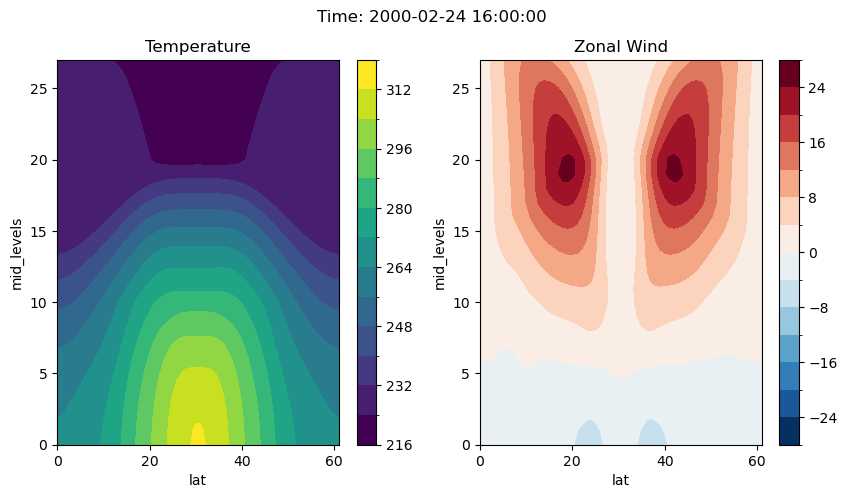

In [13]:
import climt
from sympl import PlotFunctionMonitor
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from gfs_dynamical_core import GFSDynamicalCore


def plot_function(fig, state):

    fig.set_size_inches(10, 5)

    ax = fig.add_subplot(1, 2, 1)
    state['air_temperature'].mean(dim='lon').plot.contourf(
        ax=ax, levels=16)
    ax.set_title('Temperature')

    ax = fig.add_subplot(1, 2, 2)
    state['eastward_wind'].mean(dim='lon').plot.contourf(
        ax=ax, levels=16)
    ax.set_title('Zonal Wind')

    plt.suptitle('Time: '+str(state['time']))


model_time_step = timedelta(seconds=600)
monitor = PlotFunctionMonitor(plot_function)

grid = climt.get_grid(nx=128, ny=62)

held_suarez = climt.HeldSuarez()
dycore = GFSDynamicalCore([held_suarez])
my_state = climt.get_default_state([dycore], grid_state=grid)

my_state['eastward_wind'].values[:] = np.random.randn(*my_state['eastward_wind'].shape)

for i in range(10000):
    diag, output = dycore(my_state, model_time_step)
    if (my_state['time'].hour % 2 == 0 and
            my_state['time'].minute == 0):
        print('max. zonal wind: ', np.amax(my_state['eastward_wind'].values))
        monitor.store(my_state)
    my_state.update(output)
    my_state['time'] += model_time_step

In [16]:
import warnings
warnings.simplefilter("ignore")

import climt
import sympl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

In [4]:
grid = climt.get_grid(nx=1, ny=1, nz=10)
list(grid.keys())

['atmosphere_hybrid_sigma_pressure_a_coordinate_on_interface_levels',
 'atmosphere_hybrid_sigma_pressure_b_coordinate_on_interface_levels',
 'surface_air_pressure',
 'time',
 'air_pressure',
 'air_pressure_on_interface_levels',
 'longitude',
 'latitude',
 'height_on_ice_interface_levels']

In [6]:
radiation = climt.GrayLongwaveRadiation()
state = climt.get_default_state([radiation], grid_state=grid)
list(state.keys())

['atmosphere_hybrid_sigma_pressure_a_coordinate_on_interface_levels',
 'atmosphere_hybrid_sigma_pressure_b_coordinate_on_interface_levels',
 'surface_air_pressure',
 'time',
 'air_pressure',
 'air_pressure_on_interface_levels',
 'longitude',
 'latitude',
 'height_on_ice_interface_levels',
 'longwave_optical_depth_on_interface_levels',
 'air_temperature',
 'surface_temperature']

In [7]:
def plot_1D_profile(state, tendencies=None, timestep=None, 
                    variable_name='air_temperature'):
    plt.plot(state[variable_name].values.flatten(), 
         state['air_pressure'].values.flatten(), label=state['time'])
    ax = plt.gca()
    ax.axes.invert_yaxis(), ax.set_ylim(1e5, 100.), 
    ax.set_xlabel(state[variable_name].units)
    ax.set_ylabel('Pa'), ax.set_title(variable_name.replace('_',' '));
    if tendencies is not None:
        plt.plot(state[variable_name].values.flatten() + 
                 tendencies[variable_name].values.flatten()*timestep.seconds, 
                 state['air_pressure'].values.flatten(), label=state['time']+timestep)
        plt.legend()

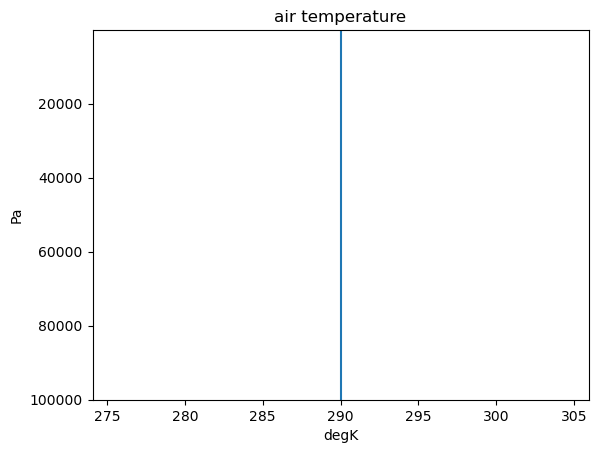

In [8]:
plot_1D_profile(state)

In [9]:
from datetime import timedelta
timestep = timedelta(minutes=20)

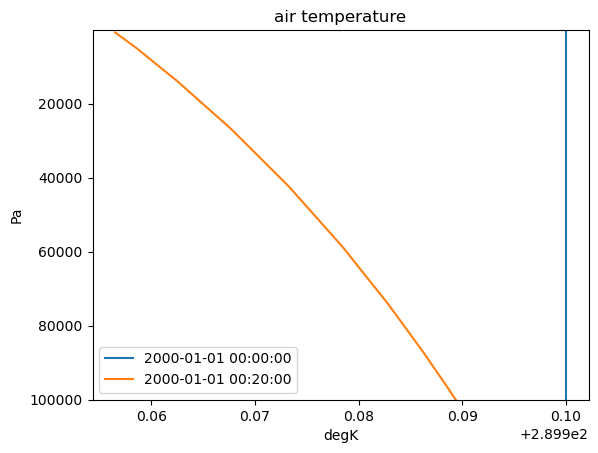

In [10]:
tendencies, diagnostics = radiation(state)
plot_1D_profile(state, tendencies, timestep)

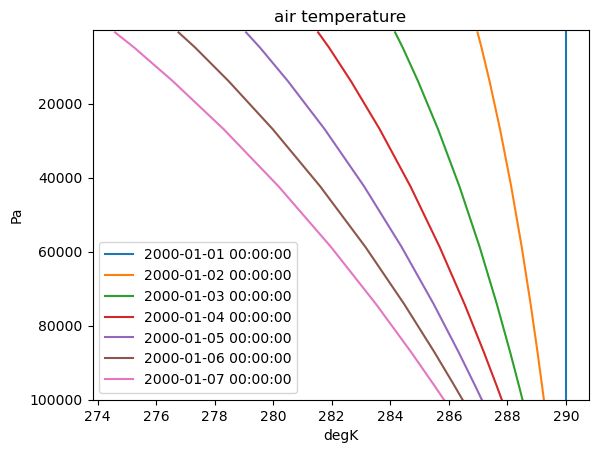

In [11]:
plot_1D_profile(state)
for i in range(3*24*6):
    tendencies, diagnostics = radiation(state)
    state['air_temperature'] += tendencies['air_temperature']*timestep.seconds 
    state['time'] += timestep
    if (i+1)%(3*24) ==0:
        plt.plot(state['air_temperature'].values.flatten(),  
                 state['air_pressure'].values.flatten(), label=state['time'])
plt.legend();

In [12]:
from datetime import timedelta
timestep = timedelta(minutes=20)

# Convection
convection = climt.EmanuelConvection()

# Radiation: only call every 1 hr
radiation_timestep = timedelta(minutes=60)
radiation = sympl.UpdateFrequencyWrapper(climt.GrayLongwaveRadiation(), 
                                         radiation_timestep)
# Simple physics (boundary layer): use tendencies to work better in spectral space
simple_physics = sympl.TimeDifferencingWrapper(climt.SimplePhysics())

In [15]:
from gfs_dynamical_core import GFSDynamicalCore
grid = climt.get_grid(nx=62, ny=62, nz=10)
held_suarez = climt.HeldSuarez()
dycore = GFSDynamicalCore([held_suarez])
state = climt.get_default_state([dycore], grid_state=grid)
list(state.keys())


['atmosphere_hybrid_sigma_pressure_a_coordinate_on_interface_levels',
 'atmosphere_hybrid_sigma_pressure_b_coordinate_on_interface_levels',
 'surface_air_pressure',
 'time',
 'air_pressure',
 'air_pressure_on_interface_levels',
 'longitude',
 'latitude',
 'height_on_ice_interface_levels',
 'air_temperature',
 'eastward_wind',
 'northward_wind',
 'divergence_of_wind',
 'atmosphere_relative_vorticity',
 'surface_geopotential',
 'specific_humidity']

In [17]:
def plot_vertical_profile(state, plot_names=['eastward_wind', 'air_temperature', 
                          'atmosphere_relative_vorticity']):
    """Plots all zonal winds for different rotation rates"""
    fig = plt.figure(figsize=(10,3))
    for i in range(len(plot_names)):
        ax = fig.add_subplot(1, 3, i+1)
        state[plot_names[i]].coords['lat'] = state['latitude'][:,0]
        state[plot_names[i]].mean(dim='lon').plot.contourf(
            ax=ax, levels=16, robust=True)
        ax.set_title(plot_names[i].replace('_',' '))
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    plt.suptitle('Vertical Profile', fontsize=16)


import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
def plot_sfc_map(state, plot_names = ['eastward_wind', 'air_temperature',
                'divergence_of_wind', 'surface_geopotential']):
    """Plots all zonal winds for different rotation rates"""
    fig = plt.figure(figsize=(9,5))
    for i in range(len(plot_names)):
        ax = fig.add_subplot(2, 2, i+1, projection=ccrs.PlateCarree())
        state[plot_names[i]].coords['lat'] = state['latitude'][:,0]
        state[plot_names[i]].coords['lon'] = state['longitude'][0]
        if 'surface' in plot_names[i]:
            plot_state = state[plot_names[i]]
        else : 
            plot_state = state[plot_names[i]][0]
        data = plot_state
        data, lon = add_cyclic_point(data, coord=state['longitude'][0])
        lat = state['latitude'][:,0]
        if np.min(data)<0.:
            levels = np.linspace(-np.max(np.abs(data)), np.max(np.abs(data)), 9)
            cmap = 'RdBu_r'
            plt.contourf(lon, lat, data, cmap=cmap, levels = levels, robust=True)

        else:
            plt.contourf(lon, lat, data, robust=True)
        plt.colorbar()
        plt.tight_layout()
        ax.set_title(plot_names[i].replace('_',' '))
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.set_aspect('auto', adjustable=None)
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.suptitle('Surface Map', fontsize=16)
    

plt.show()

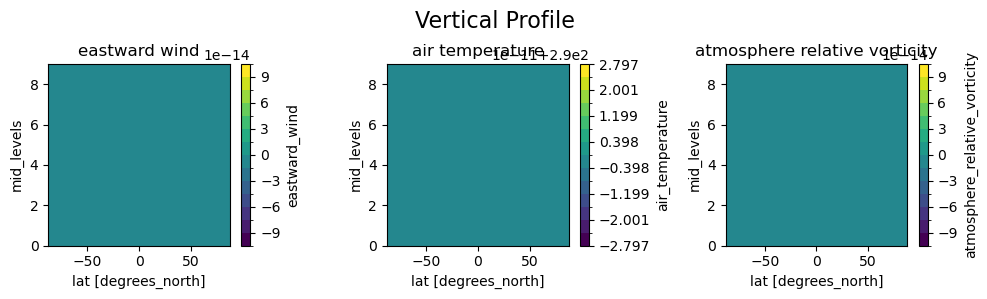

In [18]:
plot_vertical_profile(state)

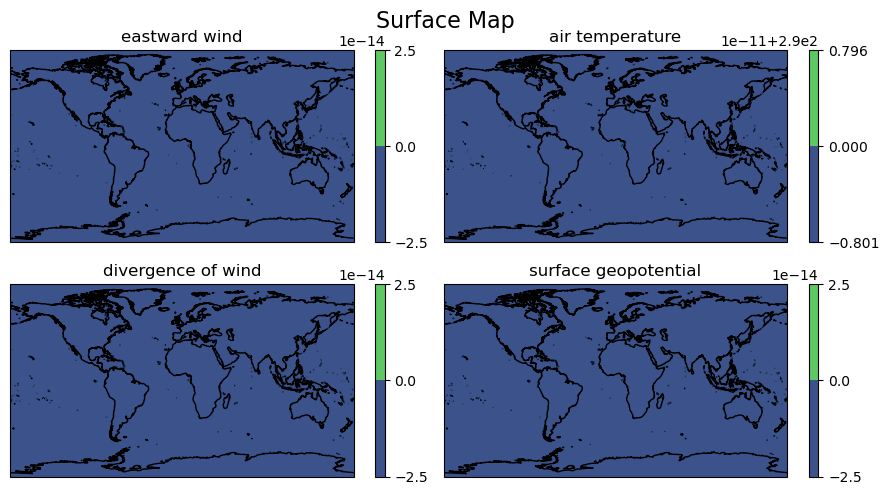

In [19]:
plot_sfc_map(state)

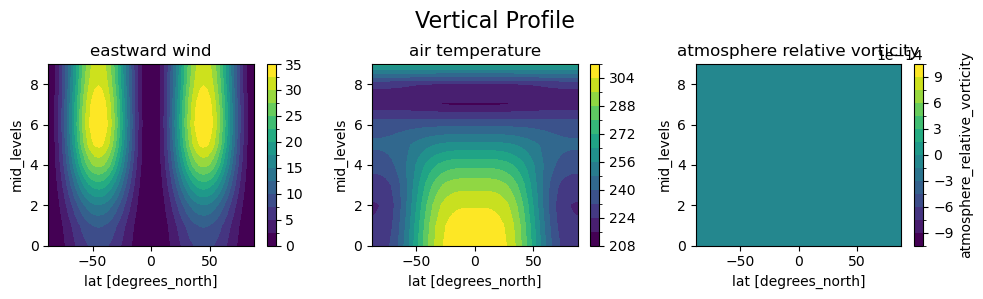

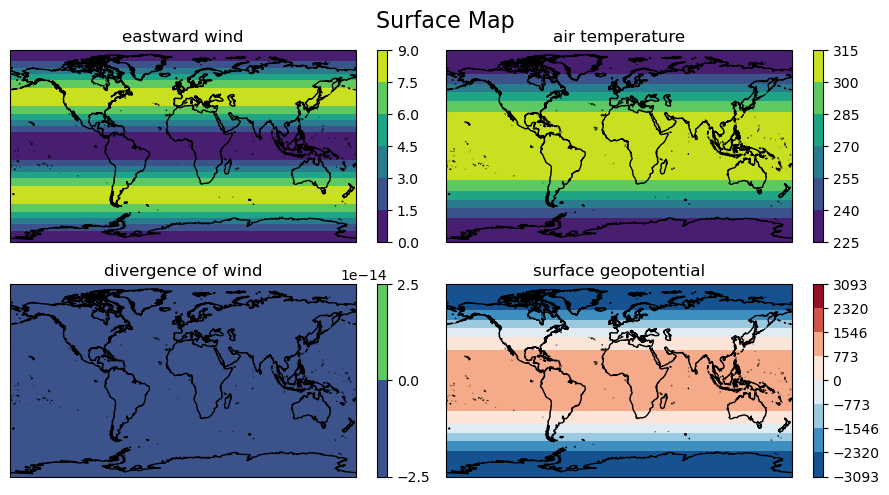

In [20]:
dcmip = climt.DcmipInitialConditions(add_perturbation=False)
init_state = dcmip(state)
state.update(init_state)
plot_vertical_profile(state)
plot_sfc_map(state)

In [22]:
diagnostics, new_state = dycore(state, timestep)

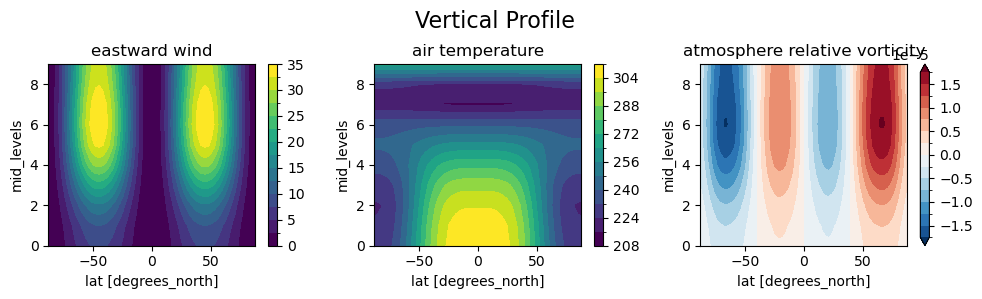

In [23]:
plot_vertical_profile(new_state)

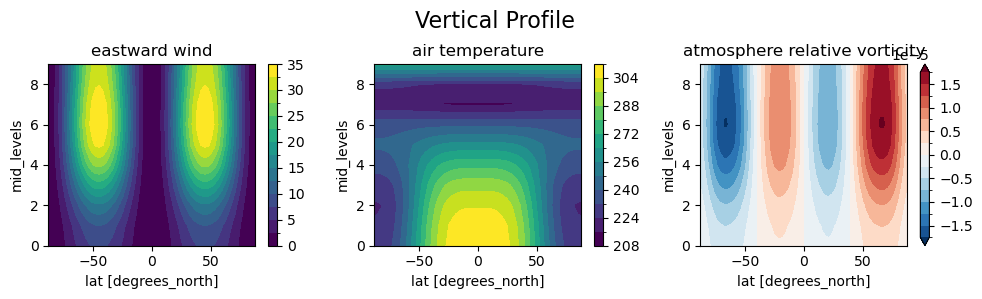

In [24]:
plot_vertical_profile(new_state)

In [25]:
state.update(diagnostics)
state.update(new_state)
state['time'] += timestep

2000-01-01 00:40:00


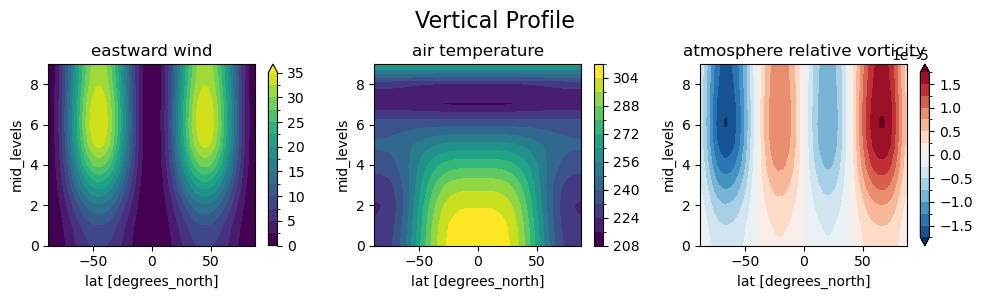

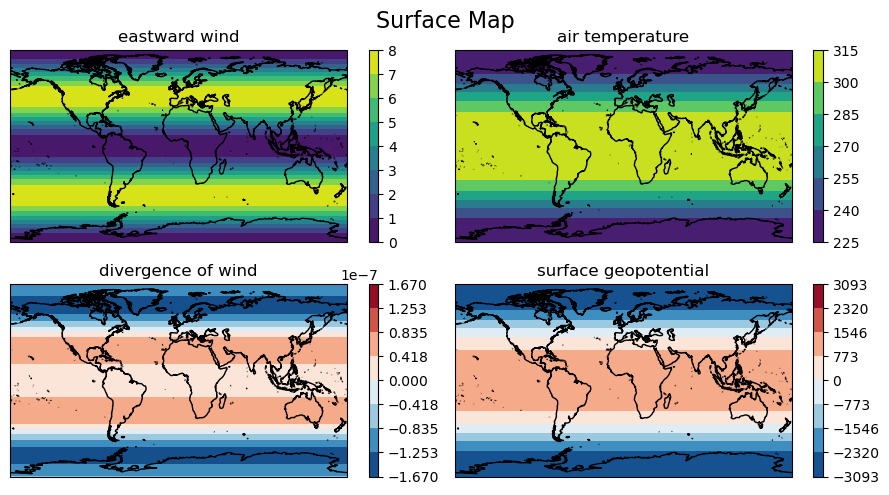

2000-01-15 00:40:00


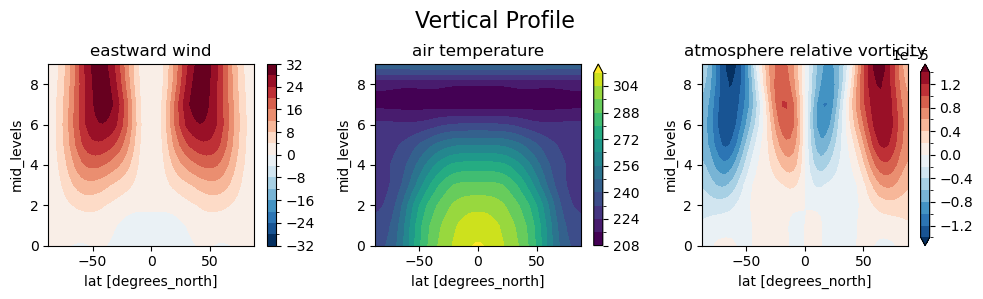

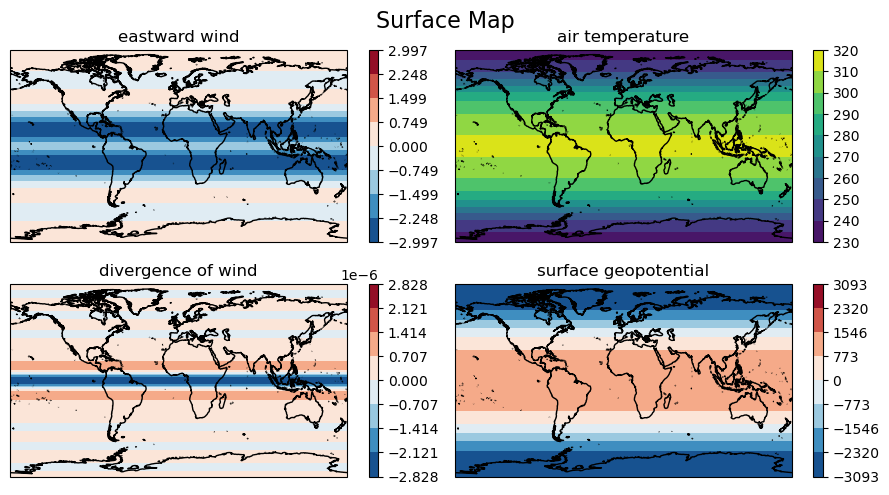

2000-01-29 00:40:00


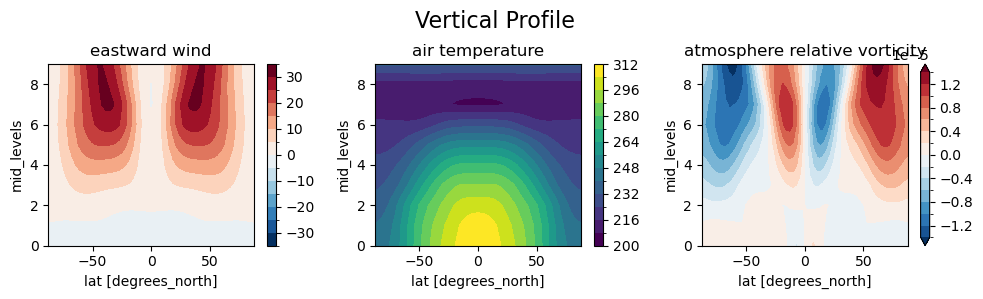

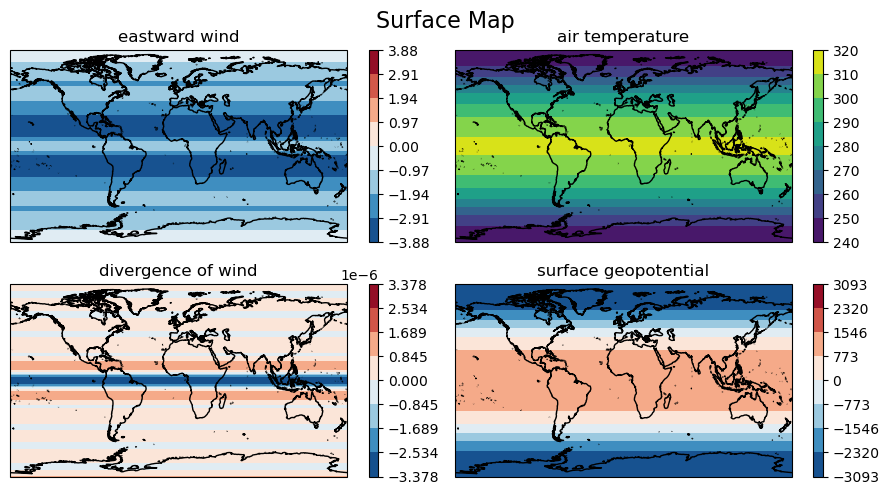

2000-02-12 00:40:00


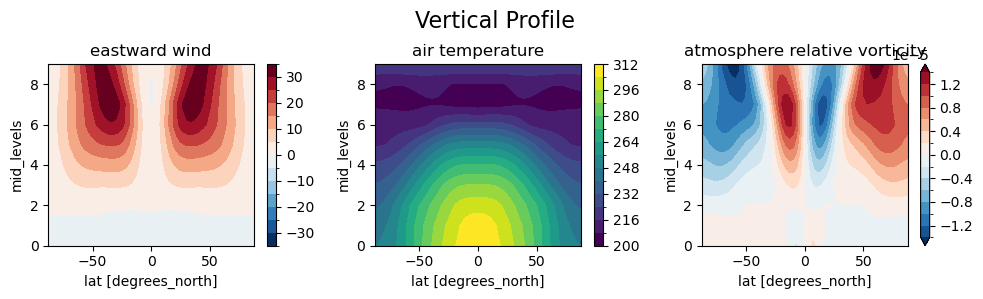

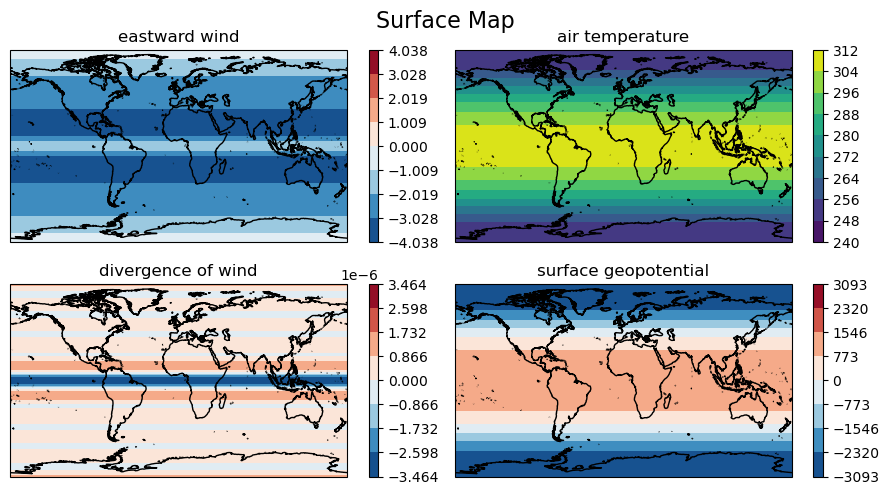

2000-02-26 00:40:00


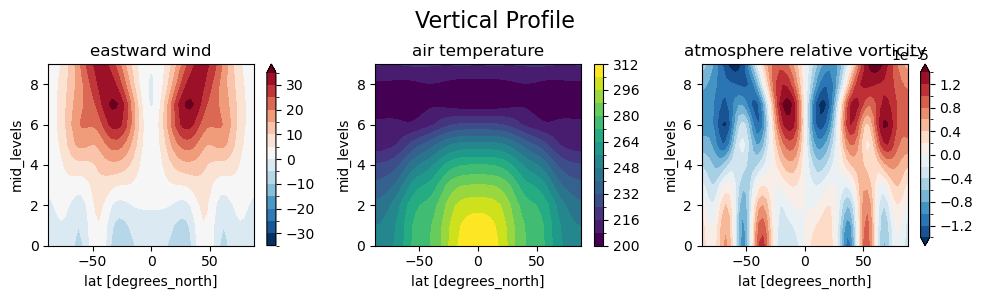

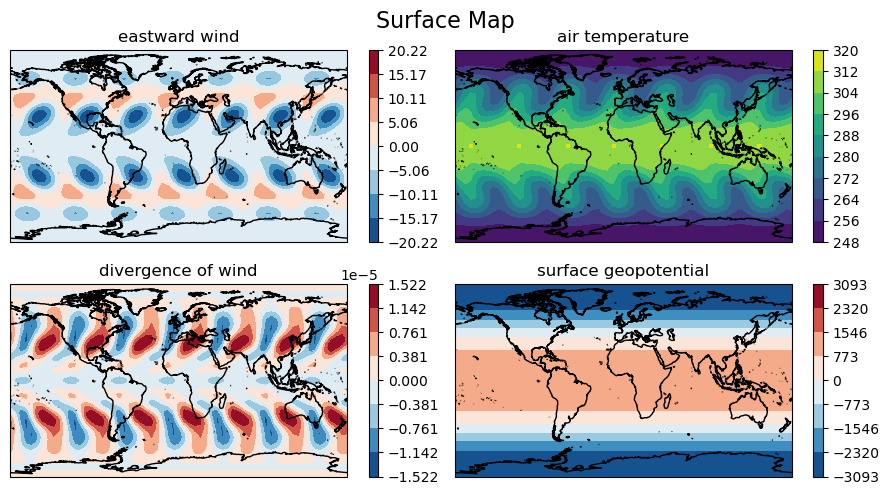

Finished at  2000-02-28 00:20:00
CPU times: user 18min 53s, sys: 9.1 s, total: 19min 2s
Wall time: 3min 2s


In [26]:
%%time
for step in range(24*3*58):
    diagnostics, new_state = dycore(state, timestep)
    state.update(new_state)
    state['time'] += timestep
    if step%(24*3*14) == 0:
        print(state['time'])
        plot_vertical_profile(new_state)
        plot_sfc_map(new_state)
        plt.show()
print("Finished at ", state['time'])